In [1]:
import functools
import jax
import jax.numpy as jnp
from jax.tree_util import Partial
from liesel_sparse import band

jax.config.update("jax_enable_x64", True)


### Kernels


def RBFKernel(sigma_f, length, x, y):
    return (
            sigma_f * jnp.exp(-(jnp.linalg.norm(x - y) ** 2) / (2 * length ** 2))
    ).astype(float)


def ExpSineSquaredKernel(sigma_f, length, periodictiy, x, y):
    return (
            sigma_f
            * jnp.exp(
        -2 * (jnp.sin(jnp.pi * jnp.linalg.norm(x - y) / periodictiy) / length) ** 2
    )
    ).astype(float)

def RationalQuadraticKernel(sigma_f, length, alpha, x, y):
    return (
            sigma_f
            * (1 + jnp.linalg.norm(x - y)**2 / (2*alpha*length*length)) ** (-alpha)
    ).astype(float)

def MaternKernel32(sigma_f, length_scale, x, y):
    arg = jnp.sqrt(3) * jnp.linalg.norm(x - y) / length_scale
    return (sigma_f * (1 + arg) * jnp.exp(-arg)).astype(float)


def MaternKernel52(sigma_f, length_scale, x, y):
    arg = jnp.sqrt(5) * jnp.linalg.norm(x - y) / length_scale
    return (sigma_f * (1 + arg + jnp.square(arg) / 3) * jnp.exp(-arg)).astype(float)


# A. Melkumyan and F. Ramos, “A Sparse Covariance Function for Exact Gaussian Process Inference in Large Datasets,” 2006.
def ExactSparse(sigma_f, length_scale, x, y):
    r = jnp.linalg.norm(x - y) / length_scale
    return jnp.where(r >= 1,
                     0,
                     (sigma_f * ((2 + jnp.cos(2 * jnp.pi * r)) / 3 * (1 - r) + jnp.sin(2 * jnp.pi * r) / (
                                 2 * jnp.pi))).astype(float))


def SphericalTapering(theta, x, y):
    # Valid taper for Matern v <= 0.5
    r = jnp.linalg.norm(x - y) / theta
    #return jnp.maximum(0, 1 - r)
    return jnp.maximum(0, 1-r)**2 * (r/2 + 1)


# TAPERING V2
def WendlandTapering(k_, theta, x, y):
    # Valid taper for Matern v <= 2.5
    r = jnp.linalg.norm(x - y) / theta
    match k_:
        case 0:
            # d = 1, k = 0
            return jnp.maximum(0, 1 - r)
        case 1:
            # d = 1, k = 1
            return jnp.maximum(0, 1 - r) ** 3 * (3 * r + 1)
        case 2:
            # d = 1, k = 2
            return jnp.maximum(0, 1 - r) ** 5 * (8 * r * r + 5 * r + 1)
        case _:
            # d = 1, k = 3
            return jnp.maximum(0, 1 - r) ** 7 * (21 * r * r * r + 19 * r * r + 7 * r + 1)


### Implementation


def cov_matrix(x1, x2, cov_function):
    # Returns the symmetric kernel matrix K.
    return jax.vmap(lambda x_: jax.vmap(lambda y_: cov_function(x_, y_))(x1))(x2)


#@jax.jit(jax.jit, static_argnames=["p"])
def log_likelihood(kernel_, params, data_x, data_y, eps, p):
    # Compute the negative marginal log likelihood.
    K_ = cov_matrix(data_x, data_x, Partial(kernel_, *params))
    Lb_, alpha_ = inv_cov_chol(K_, data_y, eps, p)

    return -(
            -0.5 * jnp.dot(data_y, alpha_)
            - (jnp.log(Lb_[0])).sum()
            - 0.5 * alpha_.shape[0] * jnp.log(2 * jnp.pi)
    )


#@functools.partial(jax.jit, static_argnames=["p"])
def inv_cov_chol(K, data_y, eps, p):
    # Get Kernel.
    # TAPERING V1
    # Ktaper = cov_matrix(data_x, data_x, Partial(WendlandTapering, 1))
    # K = K * Ktaper
    # jax.debug.print(str(jnp.count_nonzero(K)) + "/" + str(K.shape[0]**2))
    # jax.debug.print("to" + str(jnp.count_nonzero(K)))

    # TAPERING V0
    # K = jnp.where(K < 1e-5, 0, K)

    #Kp, idx = band.permute(K)
    Kp = K
    #Kp, idx = K, jnp.arange(K.shape[0])

    # Inverse permutation to map solution back
    # idx_inv = jnp.empty_like(idx).at[idx].set(jnp.arange(len(idx), dtype=jnp.int32))
    # Alt: idx_inv = jnp.argsort(idx) (O(n log n))

    # Convert to band (can refactor out)
    if p is None:
        p = int(band.bandwidth(Kp))
    Kpb = band.to_band(Kp, p)  # TODO: bandwidth

    # Add noise
    Kpb = Kpb.at[0].add(eps)

    #jax.debug.print(str(Kpb.shape[0]) + "/" + str(K.shape[0]))

    # Solve
    Lb = jax.jit(band.cholesky_band)(Kpb)
    alpha = jax.jit(band.solve_band)(Lb, data_y)

    return Lb, alpha


class GPR:
    def __init__(self, data_x, data_y, kernel_, params, eps=1e-10):
        self.data_x = data_x
        self.data_y = data_y
        self.kernel_ = kernel_
        self.covariance_function = Partial(kernel_, *params)  # ??
        self.params = params
        self.eps = eps

        self.Lb_ = None
        self.alpha_ = None
        self.idx = None
        #self.log_marginal_likelihood_value_ = log_likelihood(
        #    self.kernel_, self.params, self.data_x, self.data_y, self.eps
        #)

    # Function to predict output at new input values.
    def predict(self, at_values, return_std=False):
        if self.alpha_ is None:
            # Compute values needed for prediction after fit.
            self.K_ = cov_matrix(self.data_x, self.data_x, self.covariance_function)
            bw = int(band.bandwidth(self.K_))
            self.Lb_, self.alpha_ = inv_cov_chol(
                self.K_, self.data_y, self.eps, p = bw
            )

        K_trans = cov_matrix(self.data_x, at_values, self.covariance_function)
        y_mean = K_trans @ self.alpha_
        print("NMLL:", -(
                -0.5 * jnp.dot(self.data_y, self.alpha_)
                - (jnp.log(self.Lb_[0])).sum()
                - 0.5 * self.alpha_.shape[0] * jnp.log(2 * jnp.pi)
        ))

        if return_std:
            V = jax.scipy.linalg.solve_triangular(band.to_ltri_full(self.Lb_), K_trans.T, lower=True)
            y_var = jnp.diag(cov_matrix(at_values, at_values, self.covariance_function))
            y_var -= jnp.einsum("ij,ji->i", V.T, V)
            y_var = y_var.at[jnp.argwhere(y_var < 0)].set(0)

            return y_mean, jnp.sqrt(y_var)
        return y_mean

    # def fit(self):
    #     import optax
    #
    #     def get_update_fn(optimizer):
    #         def update(params, opt_state):
    #             grads = jax.grad(Partial(log_likelihood, self.kernel_))(params, self.data_x, self.data_y)  # ?
    #             updates, opt_state = optimizer.update(grads, opt_state, params=params)
    #             params = optax.apply_updates(params, updates)
    #             return params, opt_state
    #
    #         return jax.jit(update)
    #
    #     optimizer = optax.sgd(learning_rate=3e-3)
    #
    #     params = self.params
    #     opt_state = optimizer.init(params)
    #     update_f = get_update_fn(optimizer)
    #
    #     for j in range(1000):
    #         params, opt_state = update_f(params, opt_state)
    #
    #     self.params = params
    #     self.covariance_function = Partial(self.kernel_, *params)

    def fit(self):
        # Use BFGS for Gradient Descent to optimize mll.
        # Only one (Unbounded) run is performed.
        import jaxopt

        # :( But have to
        bw = int(band.bandwidth(cov_matrix(self.data_x, self.data_x, self.covariance_function)))

        def fwd(*args, **kwargs):
            return Partial(log_likelihood, self.kernel_, p=bw)(*args, **kwargs), \
                jax.jacfwd(Partial(log_likelihood, self.kernel_, p=bw))(*args, **kwargs)

        solver = jaxopt.LBFGS(
            fun=fwd,
            value_and_grad=True,
            maxiter=200,
            min_stepsize=1e-3,
            tol=1e-1,
            stop_if_linesearch_fails=True,
            maxls=5,
            jit=True
        )

        print(f"Starting solve...")

        soln = solver.run(
            self.params, data_x=self.data_x, data_y=self.data_y, eps=self.eps,
        )

        params, state = soln
        print(f"Final solve: {state.value=} at {params}")
        print(f"Iter: {state.iter_num=}")

        # Precompute quantities required for predictions which are independent
        # of actual query points
        self.params = jnp.where(params > 0, params, 1e-5)
        self.covariance_function = Partial(self.kernel_, *self.params)
        self.log_marginal_likelihood_value_ = log_likelihood(
            self.kernel_, self.params, self.data_x, self.data_y, self.eps, bw
        )
        self.alpha_ = None

## Compare
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

In [230]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(2)


# Toy data, Weibull
def weibull_F(x, lambda_, k_):
    return 1 - jnp.exp(-(lambda_ * x) ** k_)


# X
X = np.linspace(start=0, stop=10, num=500).reshape(-1, 1)

# True y
lam = 1 / 5;
k = 3.5
y = np.squeeze(weibull_F(X, lam, k) + rng.normal(scale=0.1 ** 2, size=X.shape))

# Preset GP mean function
estimated_y = np.squeeze(weibull_F(X, 1 / 7, 3.7))
y -= estimated_y

# Training set
training_indices = rng.choice(np.arange(y.size), size=400, replace=False)
training_indices.sort() #! Banded by default
X_train, y_train = X[training_indices], y[training_indices]

# Add observation noise
noise_std = 0.005
y_train = y_train + rng.normal(loc=0, scale=noise_std, size=y_train.shape)

# Parameters
#[0.02970224 1.20957201 0.04      ]
s = 0.01
l = 3
p = 0

theta_init = jnp.array([s, l, p], dtype=float)

-724.2698312966522 at 0.1**2 * Matern(length_scale=3, nu=1.5)
Prediction done!

NMLL: -654.6628656543917
Prediction done!



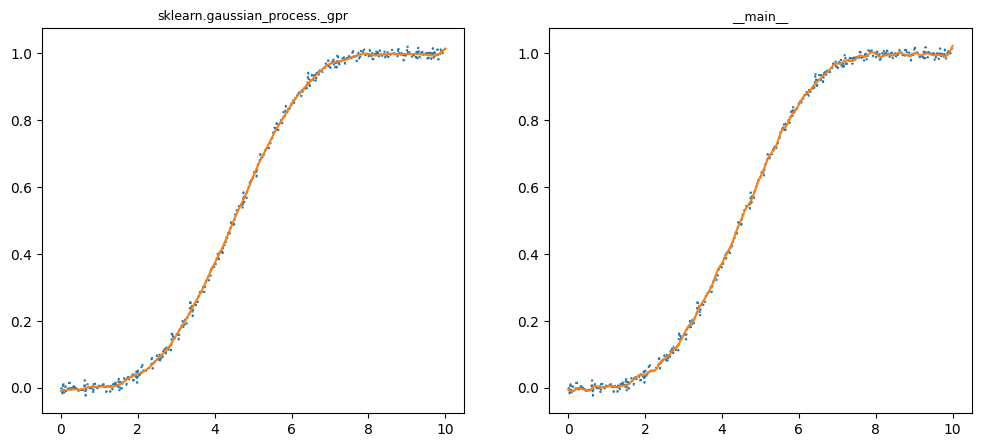

In [278]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        kernel = s * Matern(l, nu=3 / 2)
        gaussian_process_ = GaussianProcessRegressor(
            kernel=kernel,
            alpha=noise_std ** 2, optimizer=None
        )
        gaussian_process_.fit(X_train, y_train)
        print(-gaussian_process_.log_marginal_likelihood_value_, "at", gaussian_process_.kernel_)
    else:
        def kernel(s1, l1, p1, x, y):
            return MaternKernel32(s1, l1, x, y) * WendlandTapering(3, 1, x, y)
            #return ExactSparse(s1, l1/8, x, y)
        gaussian_process_ = GPR(X_train, y_train, kernel, theta_init, eps=noise_std ** 2)
        #gaussian_process_.fit()

    #mean_prediction, std_prediction = gaussian_process_.predict(X, return_std=True)
    mean_prediction = gaussian_process_.predict(X)
    print("Prediction done!\n")
    mean_prediction += estimated_y
    ax.plot(X, y + estimated_y, linestyle="dotted")  #+ estimated_y
    ax.plot(X, mean_prediction, label="Mean prediction")
    # ax.errorbar(
    #     X_train,
    #     y_train + estimated_y[training_indices],
    #     noise_std,
    #     markersize=.7,
    #     linestyle="None",
    #     color="tab:blue",
    #     marker=".",
    #     label="Observations",
    # )
    # ax.fill_between(
    #     X.ravel(),
    #     mean_prediction - 1.96 * std_prediction,
    #     mean_prediction + 1.96 * std_prediction,
    #     alpha=0.3,
    #     color="tab:orange",
    # )
    ax.set_title(gaussian_process_.__module__, fontsize=9)

plt.show()